In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

random_state = np.random.get_state()

In [2]:
class Bandit(object):
    def __init__(self, k_arm=10, epsilon=0.0, nonstationary=False, time_step=None, initial=0.0, upper_confidence_bound=None,
                 stochastic_gradient_ascent=None, stochastic_gradient_ascent_baseline=False, true_reward=0):
        self.k_arm = k_arm
        self.epsilon = epsilon
        self.nonstationary = nonstationary
        self.time_step = time_step
        self.action_indices = np.arange(self.k_arm, dtype=np.int)
        self.initial = initial
        self.UCB = upper_confidence_bound
        self.gradient = stochastic_gradient_ascent
        self.gradient_baseline = stochastic_gradient_ascent_baseline
        self.true_reward = true_reward
        self.average_reward = 0

    def reset(self):
        self.q_true = np.random.normal(loc=0, scale=1, size=self.k_arm) + self.true_reward
        self.q_estimation = np.zeros(self.k_arm) + self.initial
        self.time = 0
        self.action_count = np.zeros(self.k_arm)
        self.best_action = np.argmax(self.q_true)
        self.average_reward = 0
    
    def act(self):
        if self.UCB is not None:
            UCB_estimation = self.q_estimation + self.UCB * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        elif self.gradient is not None:
            exp_est = np.exp(self.q_estimation)
            self.actoin_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.action_indices, p=self.actoin_prob)

        if np.random.random_sample() < self.epsilon:
            return np.random.choice(self.action_indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def step(self, action):
        if self.nonstationary:  # 비정상적 문제 적용
            self.q_true += np.random.normal(loc=0, scale=0.01, size=self.q_true.shape)
            self.best_action = np.argmax(self.q_true)

        reward = np.random.normal(loc=self.q_true, scale=1)[action]

        self.time += 1
        self.action_count[action] += 1
        self.average_reward = self.average_reward + (reward - self.average_reward) / self.time

        if self.gradient is not None:
            one_hot = np.eye(self.k_arm)[action]
            if self.gradient_baseline:
                average_reward_baseline = self.average_reward
            else:
                average_reward_baseline = 0
            self.q_estimation = self.q_estimation + self.time_step * (reward - average_reward_baseline) * (one_hot - self.actoin_prob) 
        elif self.time_step is not None:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) * self.time_step
        else:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) / self.action_count[action]
        return reward

In [3]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_count = np.zeros(rewards.shape)

    for i, bandit in enumerate(bandits):
        np.random.set_state(random_state)
        for r in trange(runs, desc="epsilon = {:.02f}, nonstationary = {}, time step = {} ".format(
                                    bandit.epsilon, bandit.nonstationary, bandit.time_step)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward

                if action == bandit.best_action:
                    best_action_count[i, r, t] = 1

    mean_rewards = rewards.mean(axis=1)
    mean_best_action_count = best_action_count.mean(axis=1)
    return mean_rewards, mean_best_action_count

In [4]:
def figure_2_1():
    np.random.set_state(random_state)
    plt.violinplot(dataset=np.random.normal(loc=0, scale=1, size=10) + np.random.randn(200, 10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()

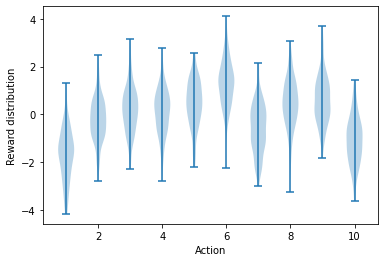

In [5]:
figure_2_1()

In [6]:
def figure_2_5(runs=2000, time=1000):
    epsilons = [0.0, 0.0, 0.0, 0.0]
    time_steps = [0.1, 0.1, 0.4, 0.4]
    stochastic_gradient_ascents = [True, True, True, True]
    gradient_baselines = [True, False, True, False]
    bandits = [Bandit(epsilon=eps, time_step=step, stochastic_gradient_ascent=gradient, stochastic_gradient_ascent_baseline=baseline, true_reward=4)
               for eps, step, gradient, baseline in zip(epsilons, time_steps, stochastic_gradient_ascents, gradient_baselines)]
    mean_rewards, mean_best_action_count = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    for eps, step, baseline, reward in zip(epsilons, time_steps, gradient_baselines, mean_rewards):
        plt.plot(reward, label="epsilon = {:.02f}, time step = {}, gradient baseline = {}".format(eps, step, baseline))
    plt.title("Stochastic Gradient Ascent")
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, step, baseline, counts in zip(epsilons, time_steps, gradient_baselines, mean_best_action_count):
        plt.plot(counts, label="epsilon = {:.02f}, time step = {}, gradient baseline = {}".format(eps, step, baseline))
    plt.title("Stochastic Gradient Ascent")
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

epsilon = 0.00, nonstationary = False, time step = 0.1 : 100%|██████████| 2000/2000 [04:38<00:00,  7.18it/s]
epsilon = 0.00, nonstationary = False, time step = 0.1 : 100%|██████████| 2000/2000 [04:39<00:00,  7.14it/s]
epsilon = 0.00, nonstationary = False, time step = 0.4 : 100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s]
epsilon = 0.00, nonstationary = False, time step = 0.4 : 100%|██████████| 2000/2000 [04:00<00:00,  8.32it/s]


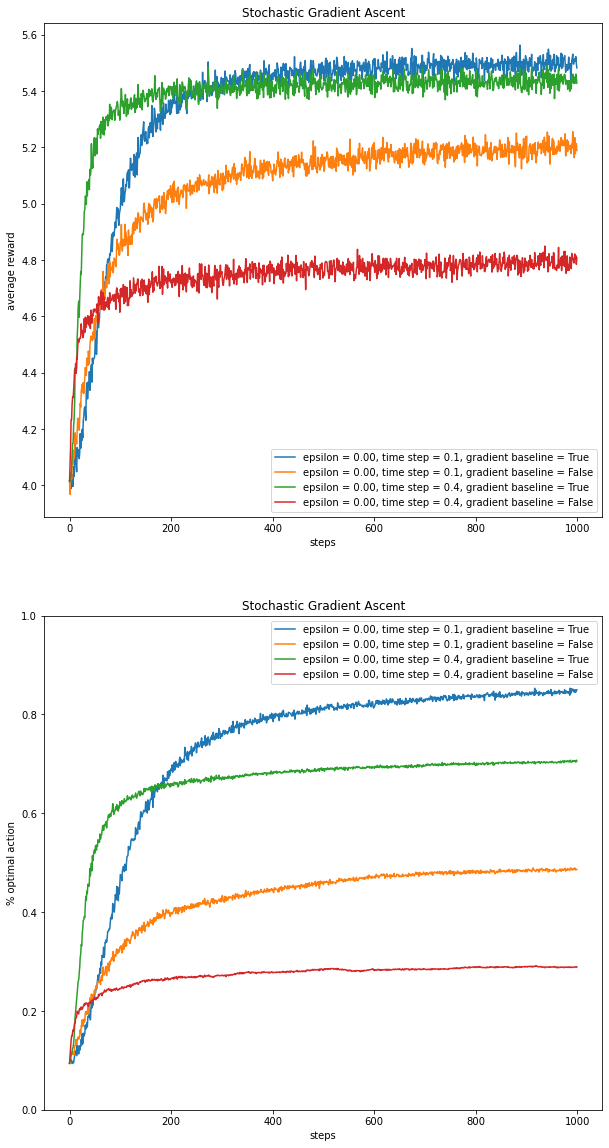

In [7]:
figure_2_5()